# Classification from 2 features with Keras

Classification using Keras, performing a classification similar to ClassificationContinuous2Features-TensorFlow. 

Based on the same data model as in the ClassificationContinuous2Features workbook.

The classification is on a single boundary (two classes) defined by a continuous function and added white noise.

In [1]:
import tensorflow as tf
from tensorflow import keras as keras
import math
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import metrics as skMetrics
import scikitplot as skplt
import scipy as sy
import pandas

In [2]:
usingTensorBoard = False

## Model

Quadratic function a boundary between positive and negative values

Adding some unknown as a Gaussian noise

The values of X are uniformly distributed and independent

In [3]:
# Two features, Gaussian noise
nFeatures = 2
def generateBatch(N):
    #
    xMin = 0
    xMax = 1
    b = 0.1
    std = 0.1
    #
    x = random.uniform(xMin, xMax, (N, 2))
    # 4th degree relation to shape the boundary
    boundary = 2*(x[:,0]**4 + (x[:,0]-0.3)**3 + b)
    # Adding some gaussian noise
    labels = boundary + random.normal(0, std, N) > x[:,1]
    return (x, labels)

### Training data

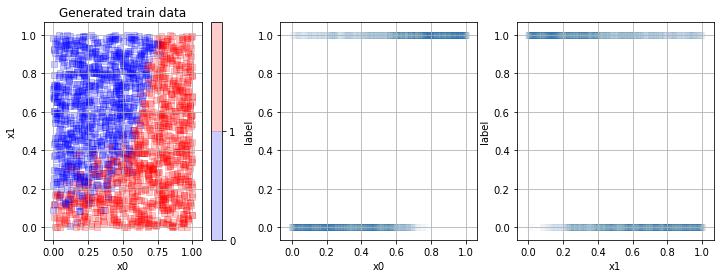

In [4]:
N = 2000
# x has 1 dim in R, label has 1 dim in B
xTrain, labelTrain = generateBatch(N)

colors = ['blue','red']

fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(xTrain[:,0], xTrain[:,1], c=labelTrain, cmap=pltcolors.ListedColormap(colors), marker=',', alpha=0.2)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Generated train data')
plt.grid()
cb = plt.colorbar()
loc = np.arange(0,1,1./len(colors))
cb.set_ticks(loc)
cb.set_ticklabels([0,1])
plt.subplot(1,3,2)
plt.scatter(xTrain[:,0], labelTrain, marker=',', alpha=0.01)
plt.xlabel('x0')
plt.ylabel('label')
plt.grid()
plt.subplot(1,3,3)
plt.scatter(xTrain[:,1], labelTrain, marker=',', alpha=0.01)
plt.xlabel('x1')
plt.ylabel('label')
plt.grid()

Bernouilli parameter of the distribution: 0.4975


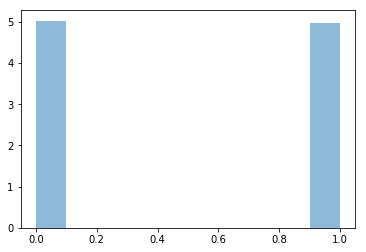

In [5]:
count, bins, ignored = plt.hist(labelTrain, 10, density=True, alpha=0.5)
p = np.mean(labelTrain)
print('Bernouilli parameter of the distribution:', p)

### Test data for verification of the model

In [6]:
xTest, labelTest = generateBatch(N)
testColors = ['navy', 'orangered']

# Using TensorFlow's Keras

## Logistic regression using Keras

Reference:
- https://www.tensorflow.org/tutorials/keras/basic_classification

In [7]:
# Number of epochs
nEpoch = 200
nBatch = 32 # 32 is default
model = keras.models.Sequential([
  keras.layers.Dense(1, activation=tf.sigmoid, input_shape=[nFeatures])
])
model.compile(optimizer='adam',
              loss='binary_crossentropy', #'sparse_categorical_crossentropy',
              metrics=['accuracy'])
callbacks = []
if usingTensorBoard:
    ks = keras.callbacks.TensorBoard(log_dir="./logs/", 
                                     histogram_freq=1, write_graph=True, write_grads=True, batch_size=1)
    callbacks = [ks]

hist = model.fit(xTrain, labelTrain, epochs=nEpoch, batch_size=nBatch, verbose=0, callbacks=callbacks)

W0722 08:01:49.993188 140735793488768 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0722 08:01:50.058033 140735793488768 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
weights, biases = model.get_weights()
print('Est W=', weights.reshape(-1), ', b=', biases[0])

Est W= [ 7.4220276 -5.6496973] , b= -0.77553964


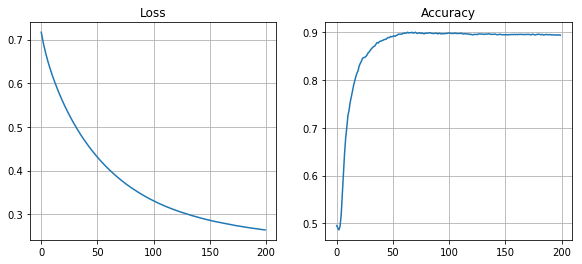

In [9]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(hist.history['loss'])
plt.grid()
plt.title('Loss')
plt.subplot(1,3,2)
plt.plot(hist.history['acc'])
plt.grid()
plt.title('Accuracy');

## Testing the model

In [10]:
#model.evaluate(xTest, labelTest)
yEst = model.predict(xTest).reshape(-1)
labelEst = yEst > 0.5
#labelEst.shape

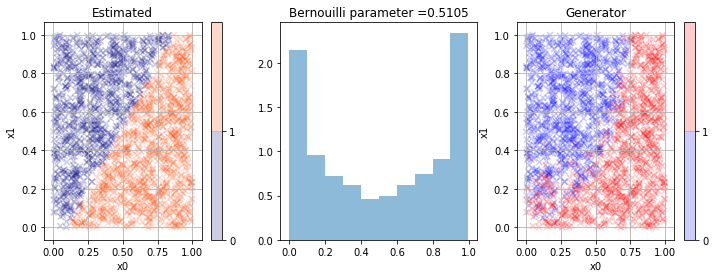

In [11]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(xTest[:,0], xTest[:,1], c=labelEst, cmap=pltcolors.ListedColormap(testColors), marker='x', alpha=0.2);
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.title('Estimated')
cb = plt.colorbar()
loc = np.arange(0,1,1./len(testColors))
cb.set_ticks(loc)
cb.set_ticklabels([0,1]);
plt.subplot(1,3,2)
plt.hist(yEst, 10, density=True, alpha=0.5)
plt.title('Bernouilli parameter =' + str(np.mean(labelEst)))
plt.subplot(1,3,3)
plt.scatter(xTest[:,0], xTest[:,1], c=labelTest, cmap=pltcolors.ListedColormap(colors), marker='x', alpha=0.2);
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.title('Generator')
cb = plt.colorbar()
loc = np.arange(0,1,1./len(colors))
cb.set_ticks(loc)
cb.set_ticklabels([0,1]);

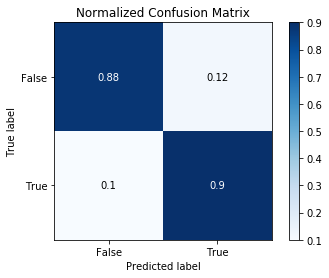

In [12]:
skplt.metrics.plot_confusion_matrix(labelTest, labelEst, normalize=True);

In [13]:
print(skMetrics.classification_report(labelTest, labelEst))

              precision    recall  f1-score   support

       False       0.90      0.88      0.89      1001
        True       0.89      0.90      0.90       999

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



In [14]:
# Visualization done using TensorBoard

#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

#from keras.utils import plot_model
#plot_model(model, to_file='model.png')

## Adding a regularizer

We have seen in ClassificationContinuous2Features-TensorFlow that the solution is not unique. Let's add a constraint through a regularizer.

Reference: https://machinelearningmastery.com/how-to-reduce-generalization-error-in-deep-neural-networks-with-activity-regularization-in-keras/

In [42]:
model2 = keras.models.Sequential([
  keras.layers.Dense(1, activation='linear', input_shape=[nFeatures],
                        bias_regularizer=keras.regularizers.l1(0.01),      # <---
                        activity_regularizer=keras.regularizers.l1(0.01)), # <----
  keras.layers.Activation(tf.sigmoid)                                      # <----
])
model2.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

callbacks = []
if usingTensorBoard:
    ks = keras.callbacks.TensorBoard(log_dir="./logs2/", 
                                     histogram_freq=1, write_graph=True, write_grads=True, batch_size=1)
    callbacks = [ks]

hist2 = model2.fit(xTrain, labelTrain, epochs=nEpoch, batch_size=nBatch, verbose=0, callbacks=callbacks)

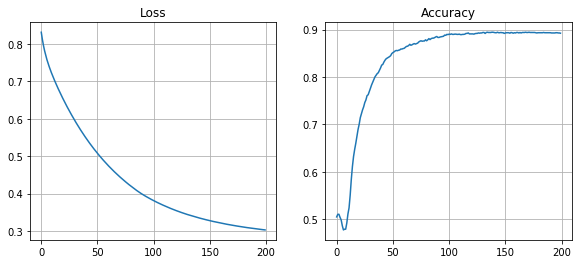

In [43]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(hist2.history['loss'])
plt.grid()
plt.title('Loss')
plt.subplot(1,3,2)
plt.plot(hist2.history['acc'])
plt.grid()
plt.title('Accuracy');

In [44]:
weights2, biases2 = model2.get_weights()
print('Regularizer W=', weights2.reshape(-1), ', b=', biases2[0])

Regularizer W= [ 6.2535577 -5.409975 ] , b= -0.2519364


With a kernel regularizer, the convergence seems faster, it depends however on the initialization values.

The weights and bias are not that different

### Testing the model with regularizer

In [45]:
yEst2 = model2.predict(xTest).reshape(-1)
labelEst2 = yEst2 > 0.5

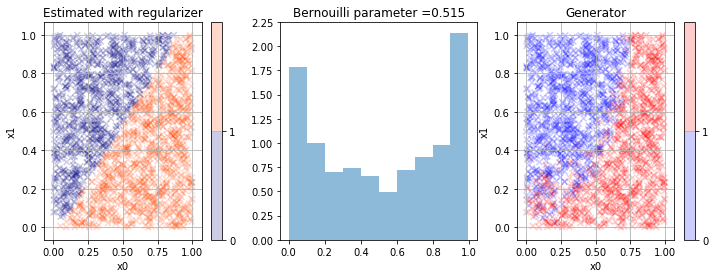

In [46]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(xTest[:,0], xTest[:,1], c=labelEst2, cmap=pltcolors.ListedColormap(testColors), marker='x', alpha=0.2);
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.title('Estimated with regularizer')
cb = plt.colorbar()
loc = np.arange(0,1,1./len(testColors))
cb.set_ticks(loc)
cb.set_ticklabels([0,1]);
plt.subplot(1,3,2)
plt.hist(yEst2, 10, density=True, alpha=0.5)
plt.title('Bernouilli parameter =' + str(np.mean(labelEst2)));
plt.subplot(1,3,3)
plt.scatter(xTest[:,0], xTest[:,1], c=labelTest, cmap=pltcolors.ListedColormap(colors), marker='x', alpha=0.2);
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.title('Generator')
cb = plt.colorbar()
loc = np.arange(0,1,1./len(colors))
cb.set_ticks(loc)
cb.set_ticklabels([0,1]);

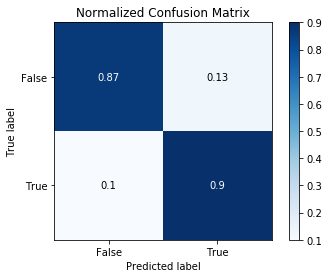

In [47]:
skplt.metrics.plot_confusion_matrix(labelTest, labelEst2, normalize=True);

# Adding capacity to the model

The above model is not able to match the actual model boundary as its capacity is a simple linear, 1st degree, separation of the plan

Let's add more neurons or more layers to our model

## Two layers (4 -> 1)

In [52]:
nEpoch3 = 400
model3 = keras.models.Sequential([
  keras.layers.Dense(4, activation='linear', input_shape=[nFeatures], # <---
                    bias_regularizer=keras.regularizers.l2(0.01),     
                    activity_regularizer=keras.regularizers.l2(0.01)),
  keras.layers.Activation(tf.nn.relu),
  #keras.layers.Dropout(0.01),
  keras.layers.Dense(1, activation=tf.sigmoid) # <---
])
model3.compile(optimizer='adam',
              loss='binary_crossentropy', #'sparse_categorical_crossentropy',
              metrics=['accuracy'])
callbacks = []
if usingTensorBoard:
    ks = keras.callbacks.TensorBoard(log_dir="./logs3/", histogram_freq=1, write_graph=True, write_grads=True, batch_size=1)
    callbacks = [ks]
    
hist3 = model3.fit(xTrain, labelTrain, epochs=nEpoch3, batch_size=nBatch, verbose=0, callbacks=callbacks)

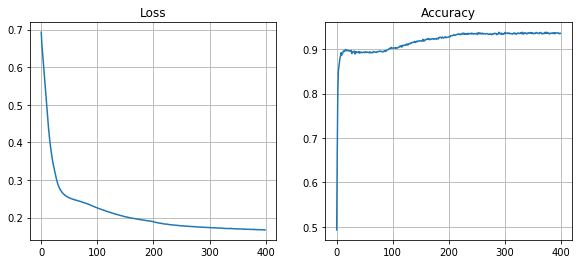

In [53]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(hist3.history['loss'])
plt.grid()
plt.title('Loss')
plt.subplot(1,3,2)
plt.plot(hist3.history['acc'])
plt.grid()
plt.title('Accuracy');

In [55]:
weights3_1, biases3_1, weights3_2, biases3_2 = model3.get_weights()
print('2 Layers')
print('W1 =', weights3_1.reshape(-1))
print('b1 =', biases3_1)
print('W2 =', weights3_2.reshape(-1))
print('b2 =', biases3_2)

2 Layers
W1 = [ 0.89607674  0.13244951  1.8995761  -1.0040556   0.26126257 -1.0518882
 -0.4490115   1.7467395 ]
b1 = [-0.5927128   0.4285829  -0.6777598   0.08586847]
W2 = [ 8.366655   5.6787176  9.223772  -5.673059 ]
b2 = [-0.0830735]


### Testing the model with two layers

In [56]:
yEst3 = model3.predict(xTest).reshape(-1)
labelEst3 = yEst3 > 0.5

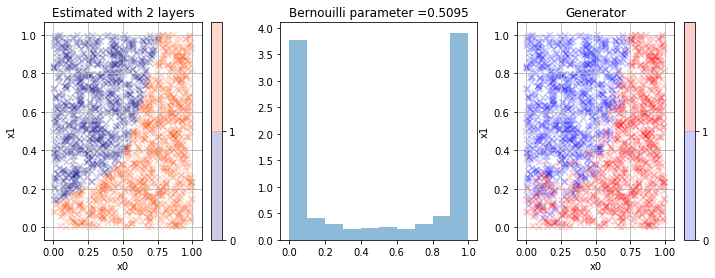

In [57]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(xTest[:,0], xTest[:,1], c=labelEst3, cmap=pltcolors.ListedColormap(testColors), marker='x', alpha=0.2);
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.title('Estimated with 2 layers')
cb = plt.colorbar()
loc = np.arange(0,1,1./len(testColors))
cb.set_ticks(loc)
cb.set_ticklabels([0,1]);
plt.subplot(1,3,2)
plt.hist(yEst3, 10, density=True, alpha=0.5)
plt.title('Bernouilli parameter =' + str(np.mean(labelEst3)));
plt.subplot(1,3,3)
plt.scatter(xTest[:,0], xTest[:,1], c=labelTest, cmap=pltcolors.ListedColormap(colors), marker='x', alpha=0.2);
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.title('Generator')
cb = plt.colorbar()
loc = np.arange(0,1,1./len(colors))
cb.set_ticks(loc)
cb.set_ticklabels([0,1]);

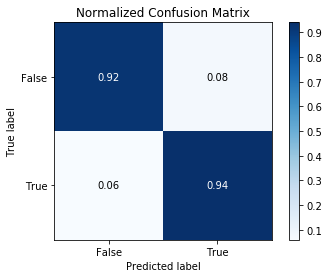

In [58]:
skplt.metrics.plot_confusion_matrix(labelTest, labelEst3, normalize=True);

In [59]:
print(skMetrics.classification_report(labelTest, labelEst3))

              precision    recall  f1-score   support

       False       0.94      0.92      0.93      1001
        True       0.93      0.94      0.93       999

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



#### Conclusion

The network if able to match much better the generation function leading to an improvement in the accuracy from 90% to ~94%, given a gaussian noise of std=0.1.

On the accuracy plot, we see that the optimization happens in two steps: initial convergence to 90% accuracy (as the simpler network),

However, the experiments have shown much more instability of the optimizer with more layers, even sometimes failing to converge.

With this network, the regularizer seems mandatory otherwise the second 